In [1]:
from os.path import join
import pandas as pd
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.text import Annotation
import re
import numpy as np

In [2]:
onet_skills = pd.read_csv(join('..', 'onet_skills_unstacked.csv'), index_col=['O*NET-SOC Code', 'Title'])

In [9]:
SAVE_FIGURES = True
PRINT_OUTPUT = True
SEED = 42

# Finding Ideal Number of Components In Mixture Model

In [4]:
aic = []
bic = []
range_components_trying = range(2, 20)
for i in range_components_trying:
    gmm = GaussianMixture(n_components=i, random_state=SEED).fit(onet_skills.values)
    aic.append(gmm.aic(onet_skills.values))
    bic.append(gmm.bic(onet_skills.values))

AttributeError: 'Axes' object has no attribute 'show'

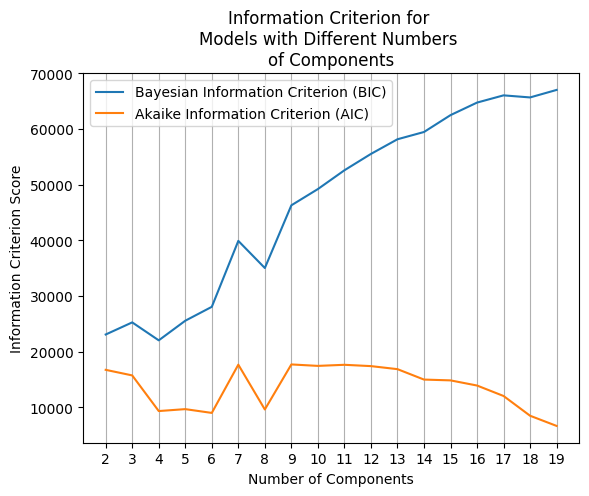

In [15]:
figure = plt.figure()
axes = figure.add_subplot(111)
axes.set_xticks(ticks = range(len(range_components_trying)), labels = range_components_trying)
axes.grid(visible=True, axis='x')
axes.set_ylabel('Information Criterion Score')
axes.set_xlabel('Number of Components')
axes.set_title('Information Criterion for \nModels with Different Numbers \nof Components')

axes.plot(bic)
axes.plot(aic)
axes.legend(['Bayesian Information Criterion (BIC)', 'Akaike Information Criterion (AIC)'])

if SAVE_FIGURES:
    figure.savefig('latent_profile_analysis.png')
if PRINT_OUTPUT:
    figure.show()
else:
    plt.close(figure)

The graphs seem to indicate that a model with <i>4 components</i> is both relatively well-performing and still parsimonious.

# Fitting and Assessing Model

In [11]:
gmm = GaussianMixture(n_components=4, random_state=SEED).fit(onet_skills.values)

onet_skills['Cluster'] = gmm.predict(onet_skills.values)

# Training Decision Tree on Assigned Clusters as an Attempted Explanation

In [13]:
decision_tree = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    random_state=SEED
).fit(
    X = onet_skills.drop(columns='Cluster'),
    y= onet_skills['Cluster']
)

/var/folders/nc/4202mlvd4hg61x79bmx7rfg00000gn/T/ipykernel_6720/4031554958.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


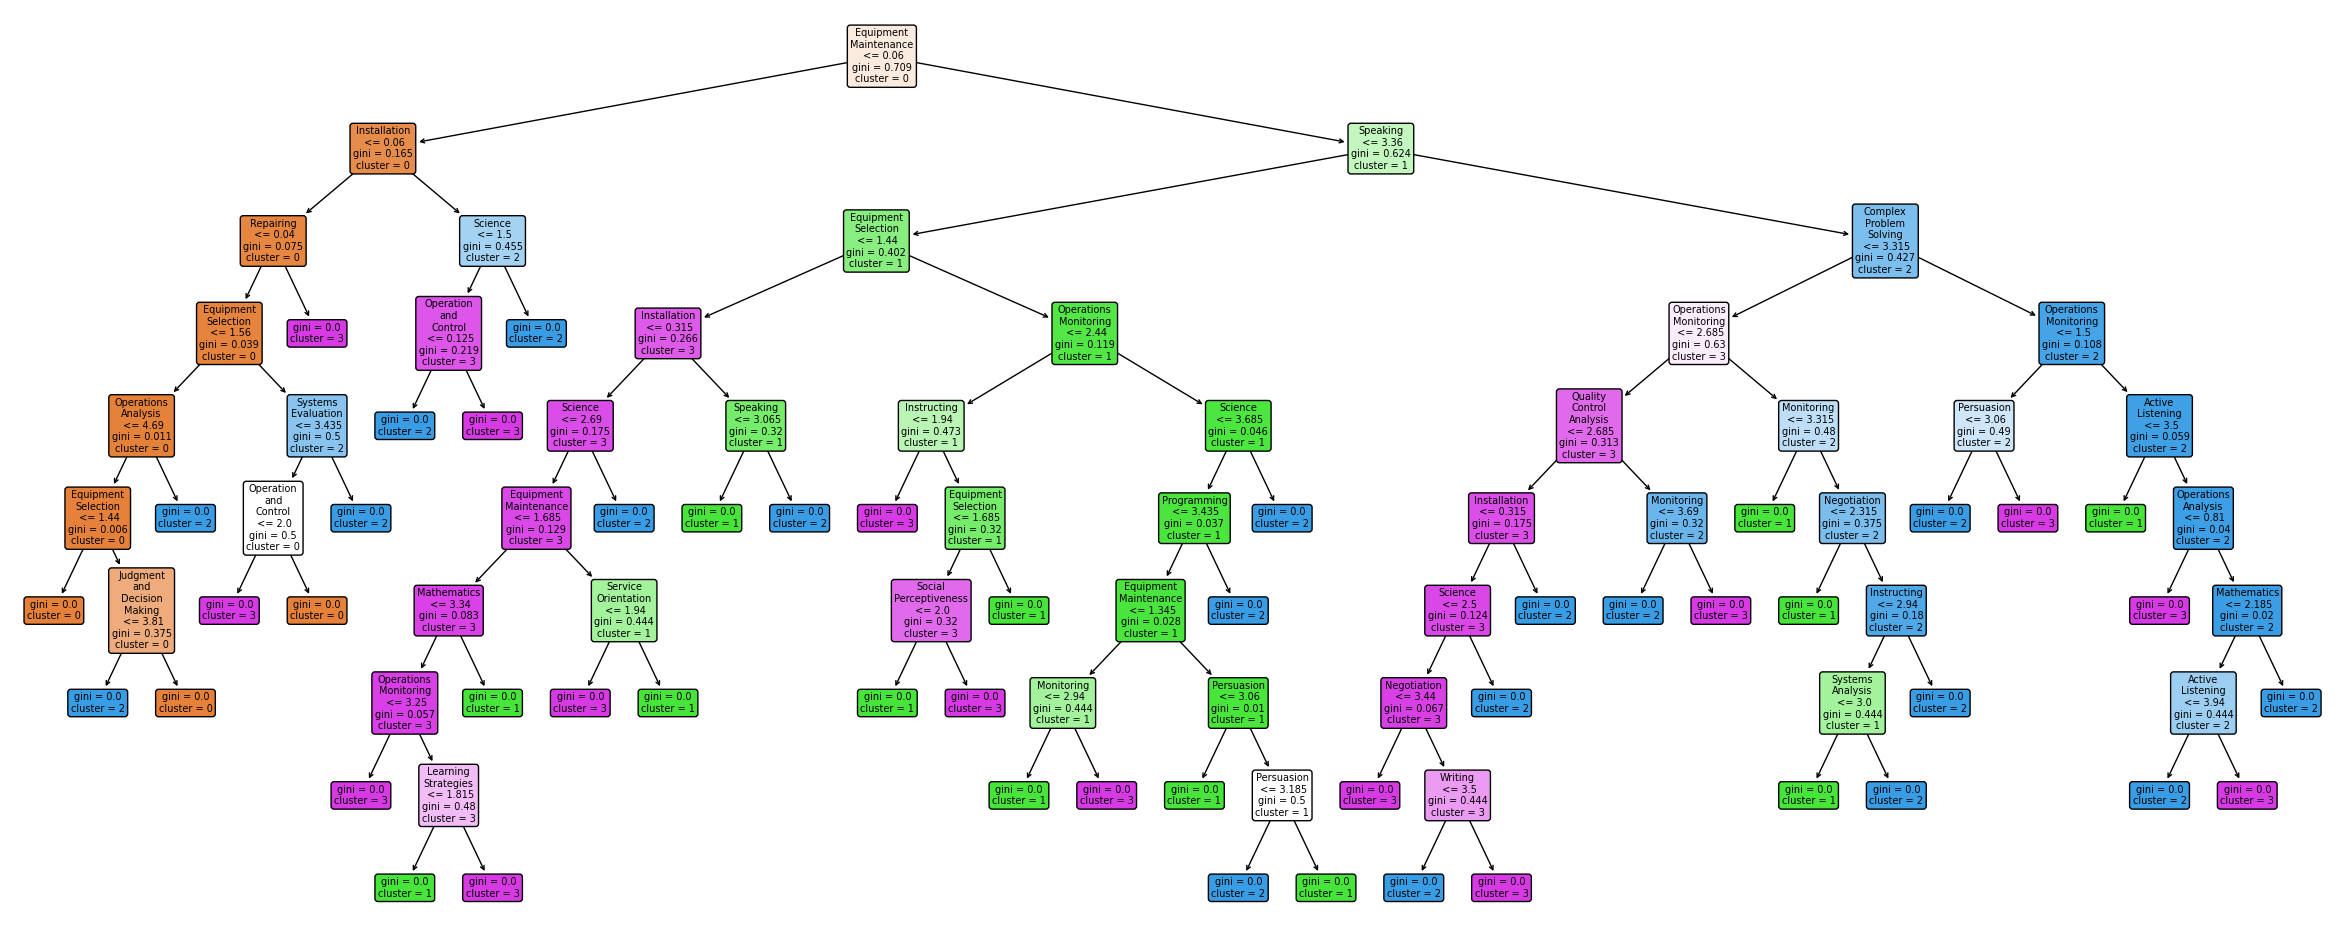

In [14]:
figure = plt.figure(figsize=(30, 12));
axes = figure.add_subplot(111);

plot_tree(
    decision_tree, 
    feature_names=onet_skills.drop(columns='Cluster').columns,
    impurity=True,
    fontsize=7, 
    rounded=True, 
    filled=True, 
    ax=axes
);

for property in axes.properties()['children']:
    # for every axes property that is a `Text` object,
    if type(property) == Annotation:
        
        text_content = property.get_text()

        #--------------------------------------------------------------------#
        # Breaking up long skill names into multiple lines
        #--------------------------------------------------------------------#
        skill_name_position = re.search(pattern="[><]", string=text_content)
        if skill_name_position:
            skill_name_end_index = skill_name_position.start() - 1
            skill_name = text_content[:skill_name_end_index + 1].replace(' ', '\n')
            text_content = skill_name + text_content[skill_name_end_index:]

        #--------------------------------------------------------------------#
        # Delete "samples" detail in each node (e.g. samples = 32)
        #--------------------------------------------------------------------#
        sample_detail = re.search(
            pattern="(samples = )[^(\\n)]*(\\n)",
            string=text_content
        )
        text_content = text_content[0:sample_detail.start()] + text_content[sample_detail.end():]

        #--------------------------------------------------------------------#
        # Replace array of cluster assignments with the mode cluster
        # and rename from "value" to "cluster"
        #--------------------------------------------------------------------#
        # find the index in text where the cluster assignments array is displayed
        values_start_index = re.search(
            pattern="(value = \[)[^\]]*(\])", 
            string=text_content
        ).start()
        # calculate the most popular cluster in this node's subsample
        most_popular_class = np.array(
            re.split(
                pattern=', |\\n',
                string = text_content[values_start_index + 8:][1:-1]
            )
        ).astype('float').argmax()
        # in the text, replace the values array with just the most popular cluster
        property.set_text(
            text_content[:values_start_index] + 'cluster = ' + str(most_popular_class)
        )

if SAVE_FIGURES:
    figure.savefig('latent_profile_analysis_decision_tree.png')
if PRINT_OUTPUT:
    figure.show()
else:
    plt.close(figure)